In [1]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import torch 
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import timm
from timm.optim import create_optimizer_v2, optimizer_kwargs
from timm import utils
from timm.loss import JsdCrossEntropy, SoftTargetCrossEntropy, BinaryCrossEntropy, LabelSmoothingCrossEntropy
from timm import scheduler
from torch.optim import Adam
from sklearn.model_selection import train_test_split

import glob
from tqdm.notebook import tqdm
import argparse
import logging
import os
import time
from collections import OrderedDict
from contextlib import suppress
from datetime import datetime
from functools import partial
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch
import torch.nn as nn
import torchvision.utils
import yaml
from torch.nn.parallel import DistributedDataParallel as NativeDDP
from PIL import Image
import torchvision

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, ConfusionMatrixDisplay, confusion_matrix, roc_curve, auc
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('The model will be running on', device, 'device')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


The model will be running on cuda:0 device


In [2]:
class BreastCancerDataset(Dataset):
    def __init__(self, data_path_file, train=True):
        super(Dataset, self).__init__()
        self.data = pd.read_csv(data_path_file,index_col=0)
        self.global_path = "/kaggle/input/meta-data/Data_image/"
        self.train = train
        if train:
            # Define the training data augmentation pipeline
            self.transform = transforms.Compose([
                transforms.Grayscale(num_output_channels=3),
                transforms.Resize(size=(224,224)),
#                 transforms.RandomResizedCrop(size=(384,384), scale=(0.8, 1), ratio=(0.45, 0.55)),
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.RandomVerticalFlip(p=0.5),
                transforms.RandomRotation(5),
                transforms.ColorJitter(brightness=0.1, contrast=0.1),
                transforms.RandomAffine(degrees=5, translate=(0.1, 0.1), scale=(0.9, 1.1)),
                transforms.ToTensor(),

                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
            ])
        else:
            # Define the validation and testing pipeline
            self.transform = transforms.Compose([
                transforms.Grayscale(num_output_channels=3),
                transforms.Resize(size=(224,224)),
#                 transforms.CenterCrop(size=224),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
            ])

    def __len__(self):
        return len(self.data)
    def zero_mean_normalize_image(self, image):
        mean = np.mean(image)
        std = np.std(image)
        normalized_image = (image - mean) / std
        return normalized_image

    def __getitem__(self, idx):
        row = self.data.iloc[idx]

        label = row['status']
        dic = {0: 'Bengin', 1:'Mag' }
        if self.train:
            path_global = f'/kaggle/input/data-clahe/Train/Train/{dic[label]}/'
        else:
            path_global = f'/kaggle/input/data-clahe/Test/Test/{dic[label]}/'

#         print(os.path.basename(row['Image']).replace('.png', ''))
        row['Image'] = row['Image'].split("\\")[1]

        image_filename = row['Image'].replace('.png', '')
        name = f"{image_filename}_{row.roatation_120}_{row.roatation_240}_{row.clahe}.png"
        name = name.replace('\\', '/').replace('Benign Masses/', '').replace('Malignant Masses/', '')
        img_path = os.path.join(path_global, name)
        
#         image = cv2.imread(img_path)
#         if self.train == False:
#             image =getRecoverScene(image, refine=True)
        image = Image.open(img_path)
#         image = Image.fromarray(image)
        labels = torch.tensor(label)

        if self.transform:
            image = self.transform(image)

        return image, labels, name
# Như vậy, bạn chỉ cần chuyển đổi ảnh xám đã xử lý thành đối tượng hình ảnh (Image) và sau đó áp dụng các biến đổi còn lại trong pipeline của bạn.

In [3]:
path_train = '/kaggle/input/data-clahe/train_aug.csv'
path_val = '/kaggle/input/data-clahe/test_aug.csv'


In [4]:
def check_exits(path, train=True):
    data = pd.read_csv(path)
    global_path = "/kaggle/input/meta-data/Data_image/"
    for idx in tqdm(data.index):
        row = data.iloc[idx]

        label = row['status']
        dic = {0: 'Bengin', 1: 'Mag'}
        if train:
            path_global = f'/kaggle/input/data-clahe/Train/Train/{dic[label]}/'
        else:
            path_global = f'/kaggle/input/data-clahe/Test/Test/{dic[label]}/'

#         print(os.path.basename(row['Image']).replace('.png', ''))
        row['Image'] = row['Image'].split("\\")[1]

        image_filename = row['Image'].replace('.png', '')
        name = f"{image_filename}_{row.roatation_120}_{row.roatation_240}_{row.clahe}.png"
        name = name.replace('\\', '/').replace('Benign Masses/', '').replace('Malignant Masses/', '')
        img_path = os.path.join(path_global, name)
        if not os.path.exists(img_path):
            print(img_path)


In [5]:
check_exits(path_train)
# "E:\Processing Data\Data_clahe\Train\Bengin\D3_D_4082_1.LEFT_MLO_0_0_0.png"
# /kaggle/input/ddsm-dataset/DDSM Dataset/DDSM Dataset/Malignant Masses/D1_A_1010_1.RIGHT_CC (2).png

  0%|          | 0/6558 [00:00<?, ?it/s]

/tmp/ipykernel_28/1961084751.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['Image'] = row['Image'].split("\\")[1]


In [6]:
check_exits(path_val, train=False)

  0%|          | 0/1095 [00:00<?, ?it/s]

/tmp/ipykernel_28/1961084751.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['Image'] = row['Image'].split("\\")[1]


In [7]:
def infor(path, name):
    data = pd.read_csv(path)
    print(name)
    print(data.status.value_counts())
#     print(data.Type.value_counts())

In [8]:
infor(path_train, 'train')

train
1    3576
0    2982
Name: status, dtype: int64


In [9]:
infor(path_val, 'val')

val
1    597
0    498
Name: status, dtype: int64


In [10]:
# Tính toán trọng số cho mỗi lớp để cân bằng dữ liệu
def compute_class_weights(labels):
    class_frequencies = torch.bincount(labels)
    total_samples = len(labels)
    class_weights = total_samples / (2.0 * class_frequencies)
    return class_weights

In [11]:
from torch.utils.data.sampler import WeightedRandomSampler
# Tạo DataLoader cho dữ liệu đã cân bằng
def create_balanced_dataloader(path_train, batch_size):
    dataframe = pd.read_csv(path_train)
    class_counts = dataframe.status.value_counts()
    class_weights = 1/class_counts
    sample_weights = [1/class_counts[i] for i in dataframe.status.values]
    train_dataset = BreastCancerDataset(path_train,train=True)
    sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(train_dataset), replacement=True)
    dataloader = DataLoader(train_dataset,batch_size=batch_size, sampler=sampler)

    return dataloader

In [12]:
# train_dataset = BreastCancerDataset(path_train,train=True)
val_dataset = BreastCancerDataset(path_val,train=False)
# test_dataset_DDSM = BreastCancerDataset(path_test_DDSM,train=False)
# train_dataset = BreastCancerDataset(path_train,train=True)
# val_dataset = BreastCancerDataset(path_val,train=False)

In [13]:
batch_size = 64
# train_loader = DataLoader(train_dataset,batch_size=batch_size,shuffle=True)
# val_loader = DataLoader(val_dataset,batch_size=batch_size,shuffle=True)
# test_loader_DDSM = DataLoader(test_dataset_DDSM,batch_size=batch_size,shuffle=True)

train_loader = create_balanced_dataloader(path_train, batch_size)
val_loader = DataLoader(val_dataset,batch_size=batch_size,shuffle=True)

In [14]:
# batch_size = 64
# train_loader = DataLoader(train_dataset,batch_size=batch_size,shuffle=True)
# val_loader = DataLoader(val_dataset,batch_size=batch_size,shuffle=True)
# # test_loader_DDSM = DataLoader(test_dataset_DDSM,batch_size=batch_size,shuffle=True)

In [15]:
def save_model(config, epochs, model, optimizer, criterion, pretrained="True"):
    """
    Function to save the trained model to disk.
    """
    torch.save({
                'epoch': epochs,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': criterion,
                }, f"/kaggle/working/{config.model}_{epochs}.pth")
    print(f'Save model --> {config.model}_{epochs}.pth')

In [16]:
def apply_softmax(y_preds):
    softmax_preds = F.softmax(y_preds, dim=1)
    return softmax_preds

In [17]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf

    def __call__(self, config, f1_scores, epochs, model, optimizer, criterion, pretrained="True"):

        score = f1_scores

        if self.best_score is None:
            self.best_score = score
            save_model(config, epochs, model, optimizer, criterion, pretrained="True")
        elif score <= self.best_score:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            save_model(config, epochs, model, optimizer, criterion, pretrained="True")
            self.counter = 0

In [18]:
def validate(
        model,
        loader,
        loss_fn,
        config,
        device=torch.device('cuda'),
        amp_autocast=suppress,
        log_suffix='',
        data_name = "val"
):  

    model.eval()
    label_list = []
    label_pred_list = []
    last_idx = len(loader) - 1
    val_loss = .0
    val_acc = .0
    f1_scr = .0
    with torch.no_grad():
        for batch_idx, (inputs, target, name) in enumerate(loader):
#             label = target
            target = F.one_hot(target, config.num_classes)
            
            inputs = inputs.to(device, dtype=torch.float)
            target = target.to(device, dtype=torch.float )

            with amp_autocast():
                output = model(inputs)
                if isinstance(output, (tuple, list)):
                    output = output[0]
                

            loss = loss_fn(output, target)

            val_loss += loss.item()
            output = apply_softmax(output)

            predicted = torch.max(output, 1)[1].to(device)
            label = torch.max(target, 1)[1].to(device)
            label_list.append(label.cpu())
            label_pred_list.append(predicted.cpu())

    # Tính toán độ chính xác cho toàn bộ tập dữ liệu validation
    label_list = np.concatenate([labels.numpy() for labels in label_list])
    label_pred_list = np.concatenate([preds.numpy() for preds in label_pred_list])
    val_acc = np.sum(label_list == label_pred_list) / len(label_list)
#     print(label_list)
    # Tính toán F1 score
    f1_scr = f1_score(label_list, label_pred_list, average='weighted')

    metrics = {
        "data": data_name,
        "acc": round(val_acc, 3),
        "loss": round(val_loss / len(loader), 3),  # Chia cho số lượng batch để tính trung bình
        "f1": round(f1_scr, 3)
    }
#     print(metrics)
    return metrics

In [19]:
def train_one_epoch(
        epoch,
        model,
        loader,
        optimizer,
        loss_fn,
        device=torch.device('cuda'),
        lr_scheduler=None,
        saver=None,
        output_dir=None,
        amp_autocast=suppress,
        loss_scaler=None,
        model_ema=None,
        mixup_fn=None,
        config=None
):
    losses_m = utils.AverageMeter()
    model.train()
    '''
    scaler: là một phần của tích hợp đào tạo dựa trên tự động hỗ trợ (Automatic Mixed Precision - AMP) trong PyTorch. 
    AMP là một kỹ thuật giúp tăng tốc độ đào tạo và giảm bộ nhớ sử dụng bằng cách sử dụng kiểu dữ liệu có độ chính xác thấp (float16)
    cho tính toán gradient và tự động chuyển đổi về kiểu dữ liệu cao hơn (float32) khi cần thiết để tránh tràn số và
    giảm thiểu sai số tính toán.
    AMP trong PyTorch sử dụng phép chia tỷ lệ gradient (gradient scaling) để tránh tràn số.
    Khi thực hiện lan truyền ngược (backpropagation), gradient được tính toán dựa trên kiểu dữ liệu float16. 
    Trong quá trình cập nhật trọng số, torch.cuda.amp.GradScaler sẽ điều chỉnh gradient sao cho giá trị của gradient 
    không bị tràn số. Nếu gradient quá lớn, nó sẽ được scale về mức an toàn để tránh tràn số khi cập nhật trọng số.
    '''
    scaler = torch.cuda.amp.GradScaler(enabled=config.apex)
    dataset_size = 0
    running_loss = 0.0
    num_batches_per_epoch = len(loader)
    num_updates = epoch * num_batches_per_epoch
    label_list = []
    label_pred_list = []
    last_idx = len(loader) - 1
    val_acc = .0     
    cnt = []
    for batch_idx, (inputs, target, name) in tqdm(enumerate(loader), total=num_batches_per_epoch):         
#         count_per_class = torch.bincount(target, minlength=2)
#         print(count_per_class)
#         cnt.append([count_per_class[0].item(), count_per_class[1].item()])
        target = F.one_hot(target, config.num_classes)
        
        inputs = inputs.to(device, dtype=torch.float)
        target = target.to(device, dtype=torch.float )
        with torch.cuda.amp.autocast(enabled=config.apex):
            output = model(inputs)
        loss = loss_fn(output, target)
        
        # đặt tất cả gradient của các tham số về 0, 
        optimizer.zero_grad()
        # Cập nhật giá trị, lưu trữ hàm loss lại
        losses_m.update(loss.item(), inputs.size(0))
        
        
        
        # Thực hiện propagation
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        "Validation"
        
        output = apply_softmax(output)
                
        predicted = torch.max(output, 1)[1].to(device)
        label = torch.max(target, 1)[1].to(device)
#         print(predicted)
        label_list.append(label.cpu())
        label_pred_list.append(predicted.cpu())
        
        if model_ema is not None:
            model_ema.update(model)
        '''
        torch.cuda.synchronize() là một hàm trong PyTorch được sử dụng để đồng bộ hóa việc thực hiện các phép tính trên GPU. Khi ta thực hiện các phép tính trên GPU, các lệnh được gửi tới GPU để thực hiện là bất đồng bộ, điều này có nghĩa là Python sẽ tiếp tục thực hiện các lệnh tiếp theo mà không chờ GPU hoàn thành phép tính. Điều này tạo ra một chút "trễ" (latency) giữa việc gửi các lệnh tính toán đến GPU và thực tế thực hiện các phép tính trên GPU.
        '''
        torch.cuda.synchronize()
        
        num_updates += 1
        '''
        : lr_scheduler là một đối tượng hoặc lớp chịu trách nhiệm điều chỉnh tốc độ học (learning rate) của bộ tối ưu hóa trong quá trình huấn luyện. Tốc độ học quyết định tốc độ mà các trọng số của mô hình được cập nhật trong quá trình huấn luyện.
        '''
        if lr_scheduler is not None:
            lr_scheduler.step_update(num_updates=num_updates, metric=losses_m.avg)
        if hasattr(optimizer, 'sync_lookahead'):
            optimizer.sync_lookahead()
    # Tính toán độ chính xác cho toàn bộ tập dữ liệu validation
    label_list = np.concatenate([labels.numpy() for labels in label_list])
    label_pred_list = np.concatenate([preds.numpy() for preds in label_pred_list])
    val_acc = np.sum(label_list == label_pred_list) / len(label_list)
    f1_scr = f1_score(label_list, label_pred_list, average='weighted')
    metrics = {
        "data": "train",
        "acc": val_acc,
        "loss": losses_m.avg,  # Chia cho số lượng batch để tính trung bình
        "f1": f1_scr
    }
#     print(cnt)
    return metrics


In [20]:
class focal_loss(nn.Module):
    def __init__(self, alpha: float = 0.25, gamma: float = 2, reduction: str = "none"):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
        
    def forward(self, inputs: torch.Tensor, targets: torch.Tensor):
        """
        Original implementation from https://github.com/facebookresearch/fvcore/blob/master/fvcore/nn/focal_loss.py .
        Loss used in RetinaNet for dense detection: https://arxiv.org/abs/1708.02002.

        Args:
            inputs: A float tensor of arbitrary shape.
                    The predictions for each example.
            targets: A float tensor with the same shape as inputs. Stores the binary
                    classification label for each element in inputs
                    (0 for the negative class and 1 for the positive class).
            alpha: (optional) Weighting factor in range (0,1) to balance
                    positive vs negative examples or -1 for ignore. Default = 0.25
            gamma: Exponent of the modulating factor (1 - p_t) to
                   balance easy vs hard examples.
            reduction: 'none' | 'mean' | 'sum'
                     'none': No reduction will be applied to the output.
                     'mean': The output will be averaged.
                     'sum': The output will be summed.
        Returns:
            Loss tensor with the reduction option applied.
        """

#         if not torch.jit.is_scripting() and not torch.jit.is_tracing():
#             _log_api_usage_once(sigmoid_focal_loss)
        p = torch.sigmoid(inputs)
        ce_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction="none")
        p_t = p * targets + (1 - p) * (1 - targets)
        loss = ce_loss * ((1 - p_t) ** self.gamma)

        if self.alpha >= 0:
            alpha_t = self.alpha * targets + (1 - self.alpha) * (1 - targets)
            loss = alpha_t * loss

        if self.reduction == "mean":
            loss = loss.mean()
        elif self.reduction == "sum":
            loss = loss.sum()

        return loss

In [21]:
class Parameter_model:
    def __init__(self):
        self.channels_last = None
        self.pretrained = False
        
        self.in_chans = 3
        self.num_classes = 2
        self.drop = 0.4
        self.drop_path = 0.2
        self.gp = 'max'
        self.num_epochs = 150

        self.lr = 0.000001
        self.grad_checkpointing = True
        self.channels_last = True
        '''
        vit_base_patch32_224.augreg_in21k_ft_in1k
        vit_large_patch16_224.augreg_in21k_ft_in1k
        efficientnetv2_s
        efficientnet_b0
        '''
        self.smoothing = 0.1
        self.min_lr = 5e-5
        self.warmup_epochs = 4
        self.warmup_lr =  3e-5
        self.eval_metric = 'loss'
        self.apex = True
        self.gem =False
        self.check_point = '/kaggle/input/checkpoint/efficientnet_b0_93.pth'
        
        self.channels_last = None
        self.pretrained = True
        self.in_chans = 3
        self.num_classes = 2

        self.model = "efficientnet_b0"
        self.min_lr = 5e-5
        self.warmup_epochs = 4
        self.warmup_lr =  3e-5
        self.eval_metric = 'loss'
        self.apex = True
        self.gem =True
        self.loss = None
        self.alpha = 0.25
        self.gamma = 2
        self.reduction = 'mean'
        self.loss = None
        self.gem = False
        self.path_checkpoint  = '/kaggle/input/checkpoint/efficientnet_b0_93.pth'

In [22]:
class mode_gem(nn.Module):    
    def __init__(self, features, pool, in_features):
        super(mode_gem, self).__init__()
        self.features = nn.Sequential(*features)
        self.fc = nn.Linear(in_features, 2)
        self.pool = pool
    
    def forward(self, x):
        o = self.features(x)
        o = self.pool(o).squeeze(-1).squeeze(-1)
        o = self.fc(o)
        return o
class GeM(nn.Module):
    def __init__(self, p=3, eps=1e-6):
        super(GeM,self).__init__()
        self.p = nn.Parameter(torch.ones(1)*p)
        self.eps = eps

    def forward(self, x):
        return self.gem(x, p=self.p, eps=self.eps)
        
    def gem(self, x, p=3, eps=1e-6):
        return F.avg_pool2d(x.clamp(min=eps).pow(p), (x.size(-2), x.size(-1))).pow(1./p)
        
    def __repr__(self):
        return self.__class__.__name__ + '(' + 'p=' + '{:.4f}'.format(self.p.data.tolist()[0]) + ', ' + 'eps=' + str(self.eps) + ')'
def create_model_gem(config):
    models_b4 = timm.create_model(
        config.model,
        pretrained=config.pretrained,
        in_chans=config.in_chans,
        num_classes=config.num_classes,
        drop_rate=config.drop,
        drop_path_rate=config.drop_path,
        global_pool=config.gp
    )
    if 'vit' in config.model:
        return models_b4
    in_features  = None
    if "convnet" in config.model or "vit" in config.model: 
        in_features  = models_b4.head.in_features    # cho convnet 
    else :
        in_features  = models_b4.classifier.in_features # cho eff
    features = list(models_b4.children())[:-2]
    pool = GeM()
    model_pool = mode_gem(features, pool, in_features)
    return model_pool

In [23]:
import torchvision.models as models
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.metrics import roc_auc_score

In [24]:
config = Parameter_model()

In [32]:
def evaluate(path_weight, namex):
    
    checkpoint = torch.load(path_weight)
    best_model_state_dict = checkpoint['model_state_dict']

    config.model = namex
    if config.gem: 
        model = create_model_gem(config)
    else:
         model = timm.create_model(
                config.model,
                pretrained=config.pretrained,
    #             in_chans=config.in_chans,
                num_classes=config.num_classes,
    #             drop_rate=config.drop,
    #             drop_path_rate=config.drop_path,
    #             global_pool=config.gp
            )

    model.load_state_dict(best_model_state_dict)
    model.to(device=device)
    model.eval()
    with torch.no_grad():
        names = []
        y_true = []
        y_pred = []
        for (inputs, labels,name) in tqdm(val_loader):
    #         names.append(name)
    #         print(list(name))
            inputs = inputs.to(device)
            labels = labels.to(device)

            model.to(device)
            outputs = model(inputs)
            outputs = apply_softmax(outputs)
    #         print(outputs)
            predicted = torch.max(outputs,dim=1)[1]

            y_true += labels.tolist()
            y_pred += predicted.tolist()
            names += list(name)
    # Calculate evaluation metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    # fpr, tpr, thresholds = roc_curve(y_true, y_pred, pos_label=3)
    # auc_score = auc(fpr, tpr)

    num_labels  =2
    y_true_one_hot = np.eye(num_labels)[y_true]
    y_pred_one_hot = np.eye(num_labels)[y_pred]
    auc_scores = []
    for label in range(num_labels):
        auc = roc_auc_score(y_true_one_hot[:, label], y_pred_one_hot[:, label])
        auc_scores.append(auc)

    # print("AUC scores for each label:", auc_scores)


    print("+++++++++++++++++++++++++++++++++++++++++++++")
    print(f"Result {namex}")
    print(f'Accuracy: {accuracy}')
    print(f'Precision: {precision}')
    print(f'Recall: {recall}')
    print(f'F1 score: {f1}')
    print(f'AUC normal: {auc_scores[0]}')
    print(f'AUC benign: {auc_scores[1]}')
    # print(f'AUC malignant: {auc_scores[2]:.2f}')

    cm = confusion_matrix(y_true, y_pred)
    cr = classification_report(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['benign','malignant'])
    disp.plot()
    plt.savefig(f'{name}.png')
    plt.show()

### EFFb0

  0%|          | 0/18 [00:00<?, ?it/s]

/tmp/ipykernel_28/3869583034.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['Image'] = row['Image'].split("\\")[1]


+++++++++++++++++++++++++++++++++++++++++++++
Result efficientnet_b0
Accuracy: 0.9726027397260274
Precision: 0.9726463638849393
Recall: 0.9726027397260274
F1 score: 0.9726114884309889
AUC normal: 0.97270993521826
AUC benign: 0.9727099352182599


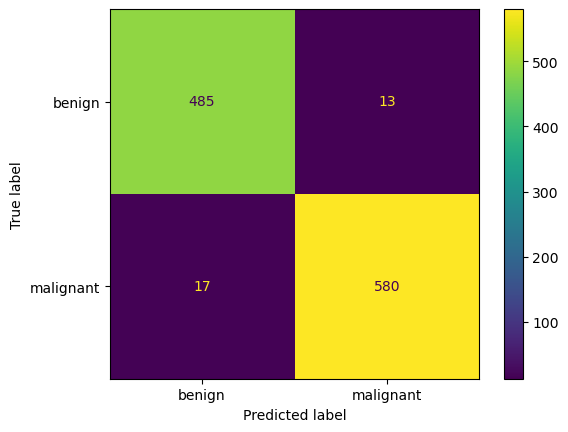

In [33]:
evaluate('/kaggle/input/result/Result/EFFb0/efficientnet_b0_97/efficientnet_b0_97.pth', 'efficientnet_b0')

### EFFb0+Havel+clahe

  0%|          | 0/18 [00:00<?, ?it/s]

/tmp/ipykernel_28/3869583034.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['Image'] = row['Image'].split("\\")[1]


+++++++++++++++++++++++++++++++++++++++++++++
Result efficientnet_b0
Accuracy: 0.9863013698630136
Precision: 0.9863229124979597
Recall: 0.9863013698630136
F1 score: 0.9863046856939408
AUC normal: 0.9864382151722468
AUC benign: 0.9864382151722468


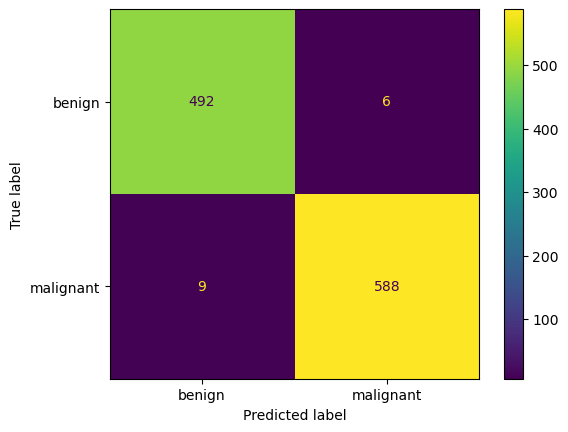

In [34]:
evaluate('/kaggle/input/result/Result/EFFb0+Havel+clahe/efficientnet_b0_127.pth', 'efficientnet_b0')

### EFFb0+Loss

  0%|          | 0/18 [00:00<?, ?it/s]

/tmp/ipykernel_28/3869583034.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['Image'] = row['Image'].split("\\")[1]


+++++++++++++++++++++++++++++++++++++++++++++
Result efficientnet_b0
Accuracy: 0.9990867579908675
Precision: 0.9990885881351744
Recall: 0.9990867579908675
F1 score: 0.9990868332356438
AUC normal: 0.9991624790619765
AUC benign: 0.9991624790619765


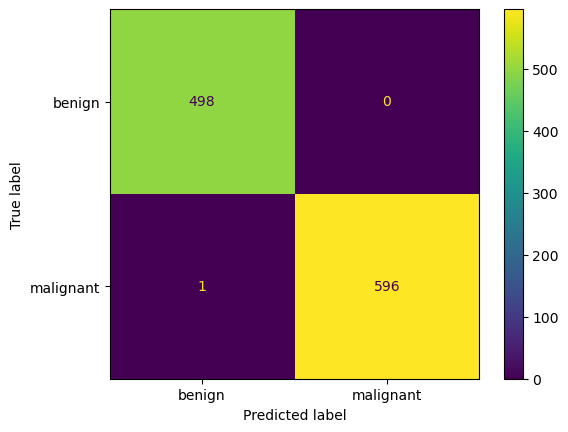

In [35]:
evaluate('/kaggle/input/result/Result/EFFb0+Loss/efficientnet_b0_6.pth', 'efficientnet_b0')

### vit_base_patch32_224.augreg_in21k_ft_in1k

  0%|          | 0/18 [00:00<?, ?it/s]

/tmp/ipykernel_28/3869583034.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['Image'] = row['Image'].split("\\")[1]


+++++++++++++++++++++++++++++++++++++++++++++
Result vit_base_patch32_224.augreg_in21k_ft_in1k
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 score: 1.0
AUC normal: 1.0
AUC benign: 1.0


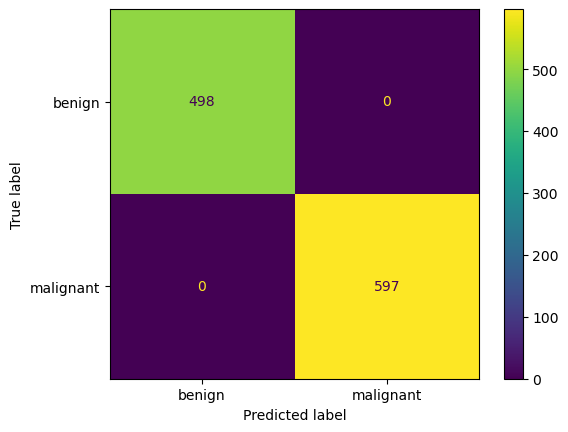

In [36]:
evaluate('/kaggle/input/result/Result/Vit/vit_base_patch32_224.augreg_in21k_ft_in1k_13.pth', 'vit_base_patch32_224.augreg_in21k_ft_in1k')